<a href="https://colab.research.google.com/github/KlymentievMaksym/IntelOb/blob/main/Lab3/Lab3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from os import listdir, remove

import cv2

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
layers = tf.keras.layers

from tensorflow.keras.utils import to_categorical

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Read Data

In [4]:
data = []
labels = []
remove_do = False
# remove_do = True

size = (128, 128)

# path  = "./app/Lab3/Data/Images"
# path  = "./drive/MyDrive/Data/Images"
path  = "./Data/Images"

images = listdir(path)

for category in tqdm(images):
    for image in listdir(f"{path}/{category}"):
        try:
            filepath = f"{path}/{category}/{image}"
            # filepath
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            img = img / 255.0
            data.append(img)
            labels.append(category)
        except Exception as e:
            if remove_do:
                remove(filepath)
            # print(filepath, e)

plt.show()
data = np.array(data)
labels = np.array(labels)

100%|██████████| 67/67 [02:50<00:00,  2.55s/it]


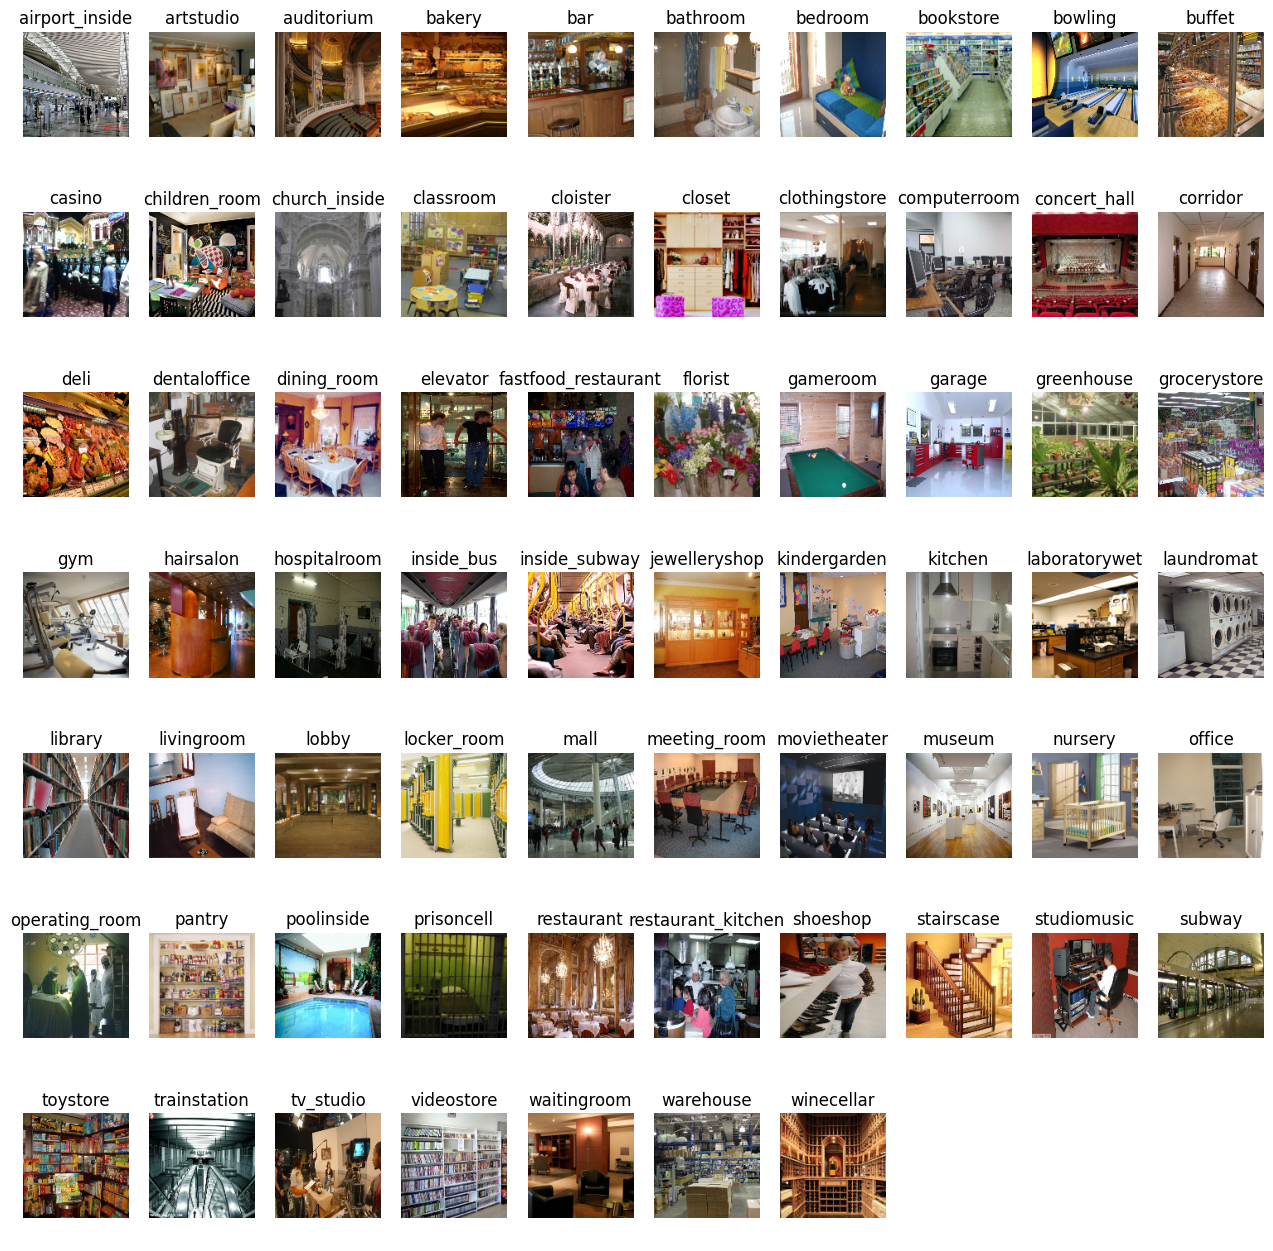

In [5]:
subplot_size = len(images)

fig, ax = plt.subplots(subplot_size//10 + 1, 10, figsize=(16, 16))
plt.axis('off')

for axe in ax:
    for axee in axe:
        axee.axis('off')


for category in images:
    filepath = path + "/" + category + "/" + listdir(f"{path}/{category}")[0]
    # print(filepath)
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    img = img / 255.0
    ax[images.index(category) // 10, images.index(category) % 10].imshow(img)
    ax[images.index(category) // 10, images.index(category) % 10].set_title(category)
plt.show()


In [6]:
labels.shape

(15590,)

In [7]:
data.shape

(15590, 128, 128, 3)

# Transform Data

In [8]:
string = labels.copy()
string = string[sorted(np.unique(string, return_index=True)[1])]
str_to_int = dict(zip(string, range(len(string))))
int_to_str = dict(zip(range(len(string)), string))


In [9]:
labels


array(['airport_inside', 'airport_inside', 'airport_inside', ...,
       'winecellar', 'winecellar', 'winecellar'], dtype='<U19')

In [10]:
def transform(x):
    return str_to_int[x]
if labels.dtype == "<U19":
    labels = np.array(list(map(transform, labels)))
labels

array([ 0,  0,  0, ..., 66, 66, 66])

In [11]:
# data = data[...,::-1]

# Split Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

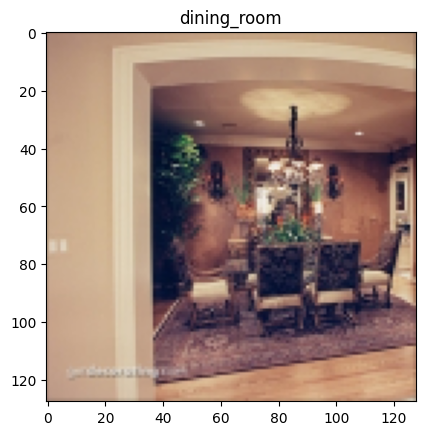

In [13]:
integer = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[integer])
plt.title(int_to_str[np.argmax(y_train[integer])])
plt.show()

# Help Fuctions

In [20]:
filepath_save = "./Models/Model_epoch{epoch:02d}_valAcc{val_accuracy:.2f}_valLoss{val_loss:.2f}.keras"
filepath_backup = "./Backups/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath_save, monitor='val_accuracy', save_best_only=True),
    tf.keras.callbacks.BackupAndRestore(filepath_backup)
]
# callbacks = tf.keras.callbacks.CallbackList(callbacks, add_history=True)

In [21]:
def display_history(history, names, title):
    plt.figure()
    plt.title(title)
    plt.plot(history.history[names[0]], label=names[0])
    plt.plot(history.history[names[1]], label=names[1])
    plt.xlabel("Epochs")
    plt.ylabel(names[0])
    plt.legend()
    plt.show()

def predict_random(model, data_x=X_test, data_y=y_test):
    choose = np.random.randint(0, data_x.shape[0])
    plt.imshow(data_x[choose])
    predictions = model.predict(data_x)
    # plt.title(f'Predicted Object: {np.argmax(predictions[choose]) + 1} | Real Object: {np.argmax(data_y[choose]) + 1}')
    plt.title(f'Predicted Object: {int_to_str[np.argmax(predictions[choose])]} | Real Object: {int_to_str[np.argmax(data_y[choose])]}')

def predict(model, batch_size=64, epochs=40, val_split=0.2):
    # history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=callbacks)
    if isinstance(val_split, float):
        history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks)
    elif isinstance(val_split, tuple):
        history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=val_split, callbacks=callbacks)
    display_history(history, ['loss', 'val_loss'], "Loss")
    display_history(history, ['accuracy', 'val_accuracy'], "Accuracy")
    model.evaluate(X_test, y_test)
    predict_random(model, X_test, y_test)

# Baseline

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 67)             │        17,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,407,107 (32.07 MB)

 Trainable params: 8,407,043 (32.07 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 92s 569ms/step - Top2: 0.0659 - accuracy: 0.0347 - loss: 5.6142 - val_Top2: 0.0954 - val_accuracy: 0.0501 - val_loss: 4.1613
Epoch 2/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 87s 560ms/step - Top2: 0.0903 - accuracy: 0.0470 - loss: 4.1508 - val_Top2: 0.0958 - val_accuracy: 0.0497 - val_loss: 4.1198
Epoch 3/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 85s 547ms/step - Top2: 0.0917 - accuracy: 0.0412 - loss: 4.1082 - val_Top2: 0.0978 - val_accuracy: 0.0513 - val_loss: 4.0911
Epoch 4/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 84s 541ms/step - Top2: 0.0960 - accuracy: 0.0510 - loss: 4.0799 - val_Top2: 0.0830 - val_accuracy: 0.0477 - val_loss: 4.3897
Epoch 5/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 534ms/step - Top2: 0.0960 - accuracy: 0.0481 - loss: 4.0435 - val_Top2: 0.0966 - val_accuracy: 0.0485 - val_loss: 4.0160
Epoch 6/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 84s 538ms/step - Top2: 0.0992 - accuracy: 0.0522 - loss: 3.9927 - val_Top2: 0.1110 - val_accuracy: 0.0609 - val_loss: 3.9871
Epoch 7/40

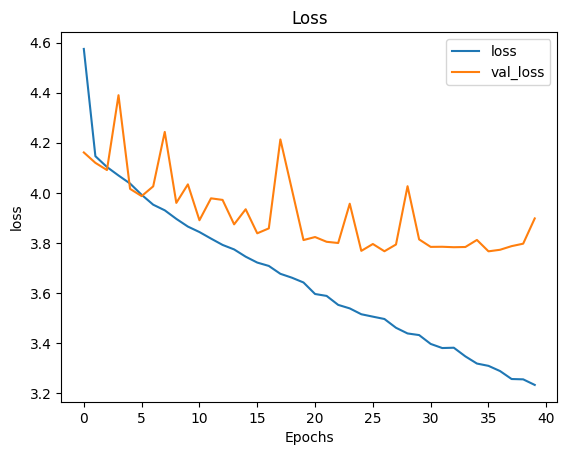

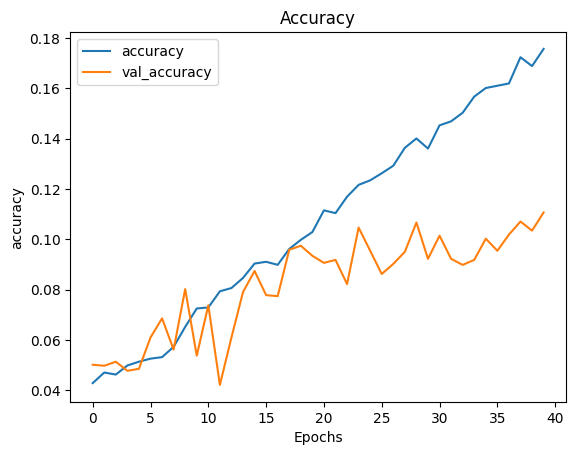

98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - Top2: 0.1827 - accuracy: 0.1004 - loss: 3.9639
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


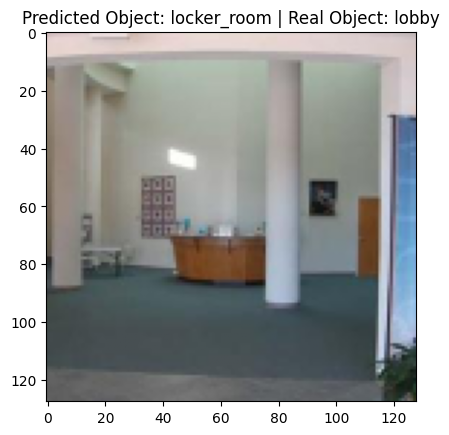

In [32]:
model_baseline = tf.keras.models.Sequential(
    [
        layers.Input(shape=(*size, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_test.shape[1], activation='softmax')
    ]
)

model_baseline.summary()
model_baseline.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
predict(model_baseline, 64, 40)

# More Conv2D

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 67)             │        17,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,163 (2.11 MB)

 Trainable params: 552,035 (2.11 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 79s 490ms/step - Top2: 0.0752 - accuracy: 0.0422 - loss: 4.5881 - val_Top2: 0.0938 - val_accuracy: 0.0409 - val_loss: 9.8107
Epoch 2/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 77s 494ms/step - Top2: 0.1484 - accuracy: 0.0848 - loss: 3.8836 - val_Top2: 0.0741 - val_accuracy: 0.0353 - val_loss: 7.0671
Epoch 3/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 73s 471ms/step - Top2: 0.1668 - accuracy: 0.0955 - loss: 3.7479 - val_Top2: 0.1363 - val_accuracy: 0.0733 - val_loss: 4.2257
Epoch 4/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 471ms/step - Top2: 0.1891 - accuracy: 0.1072 - loss: 3.6667 - val_Top2: 0.2281 - val_accuracy: 0.1379 - val_loss: 3.5817
Epoch 5/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - Top2: 0.2116 - accuracy: 0.1240 - loss: 3.5583 - val_Top2: 0.2224 - val_accuracy: 0.1415 - val_loss: 3.5198
Epoch 6/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 76s 487ms/step - Top2: 0.2350 - accuracy: 0.1444 - loss: 3.4787 - val_Top2: 0.2725 - val_accuracy: 0.1772 - val_loss: 3.3932
Epoch 7/40

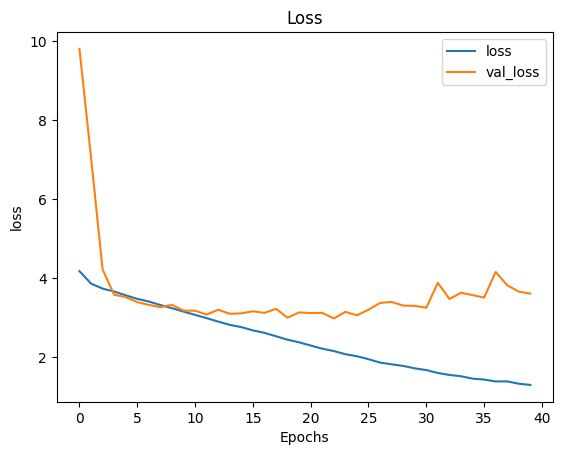

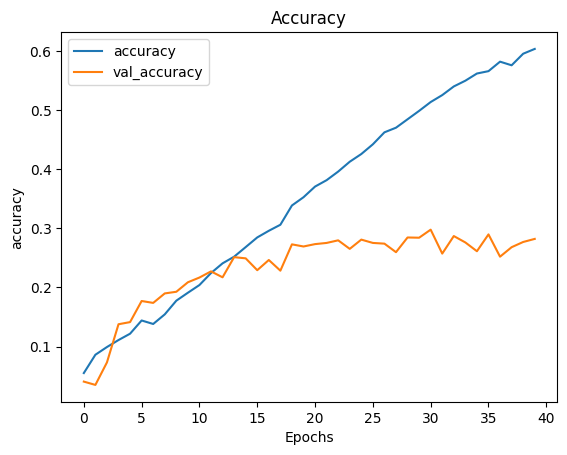

98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - Top2: 0.3768 - accuracy: 0.2451 - loss: 3.6327
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


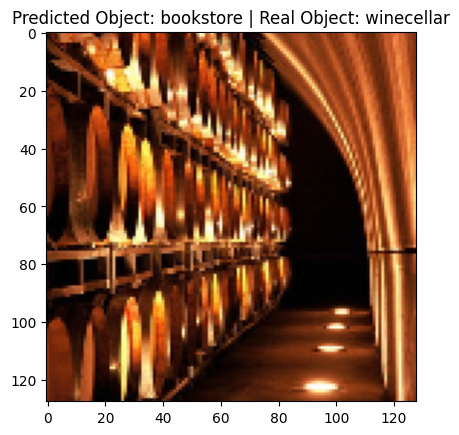

In [33]:
model_more_conv = tf.keras.models.Sequential(
    [
        layers.Input(shape=(*size, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_test.shape[1], activation='softmax')
    ]
)

model_more_conv.summary()
model_more_conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
predict(model_more_conv, 64, 40)

# Even more Conv2D

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 67)             │        17,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,019 (273.51 KB)

 Trainable params: 69,827 (272.76 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - Top2: 0.0989 - accuracy: 0.0580 - loss: 4.4232 - val_Top2: 0.0325 - val_accuracy: 0.0132 - val_loss: 7.2425
Epoch 2/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 73s 467ms/step - Top2: 0.1901 - accuracy: 0.1053 - loss: 3.6161 - val_Top2: 0.0561 - val_accuracy: 0.0144 - val_loss: 8.3714
Epoch 3/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 73s 465ms/step - Top2: 0.2347 - accuracy: 0.1381 - loss: 3.4377 - val_Top2: 0.0822 - val_accuracy: 0.0425 - val_loss: 5.5890
Epoch 4/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 72s 459ms/step - Top2: 0.2641 - accuracy: 0.1608 - loss: 3.2906 - val_Top2: 0.2377 - val_accuracy: 0.1539 - val_loss: 3.5151
Epoch 5/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 72s 463ms/step - Top2: 0.2918 - accuracy: 0.1887 - loss: 3.1663 - val_Top2: 0.3014 - val_accuracy: 0.2020 - val_loss: 3.1529
Epoch 6/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 73s 466ms/step - Top2: 0.3273 - accuracy: 0.2115 - loss: 3.0338 - val_Top2: 0.2978 - val_accuracy: 0.2004 - val_loss: 3.3732
Epoch 7/40

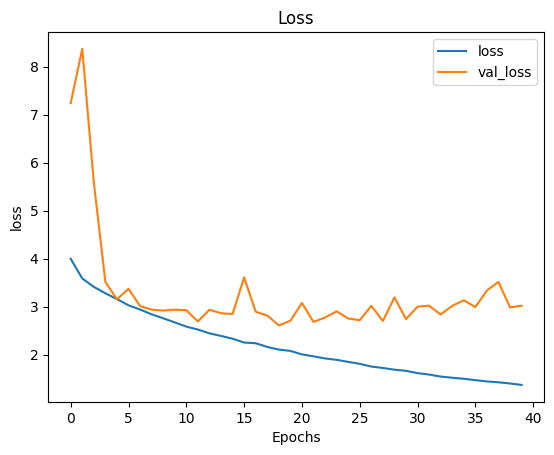

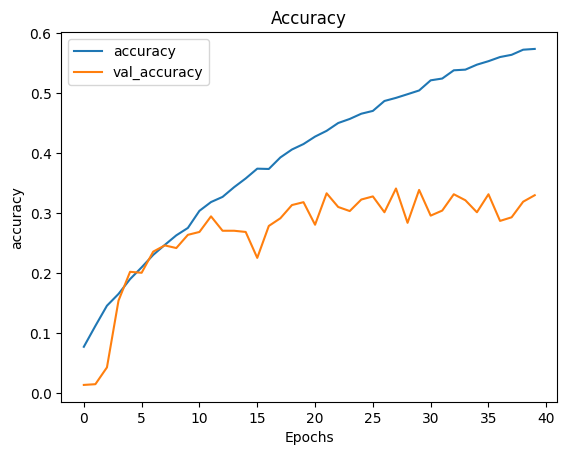

98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - Top2: 0.4589 - accuracy: 0.3051 - loss: 2.9885
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


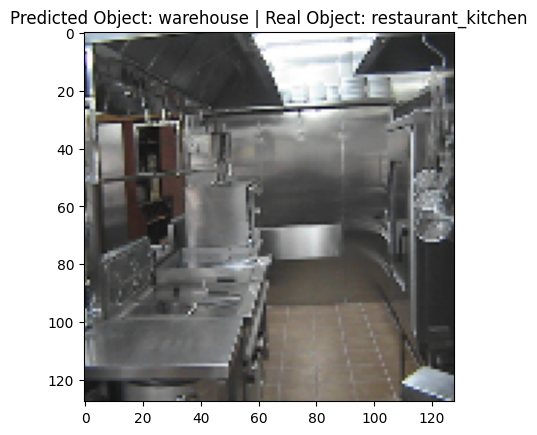

In [34]:
model_even_more_conv = tf.keras.models.Sequential(
    [
        layers.Input(shape=(*size, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_test.shape[1], activation='softmax')
    ]
)

model_even_more_conv.summary()
model_even_more_conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
predict(model_even_more_conv, 64, 40)

# More Conv2D with more Filters

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 67)             │        17,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,691 (948.01 KB)

 Trainable params: 242,243 (946.26 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 88s 526ms/step - Top2: 0.1020 - accuracy: 0.0565 - loss: 4.4775 - val_Top2: 0.0625 - val_accuracy: 0.0132 - val_loss: 12.0063
Epoch 2/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 79s 508ms/step - Top2: 0.1732 - accuracy: 0.1011 - loss: 3.7536 - val_Top2: 0.0497 - val_accuracy: 0.0132 - val_loss: 13.9985
Epoch 3/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 78s 500ms/step - Top2: 0.2224 - accuracy: 0.1288 - loss: 3.5337 - val_Top2: 0.0938 - val_accuracy: 0.0509 - val_loss: 5.7350
Epoch 4/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 80s 514ms/step - Top2: 0.2505 - accuracy: 0.1466 - loss: 3.4001 - val_Top2: 0.2277 - val_accuracy: 0.1547 - val_loss: 3.7932
Epoch 5/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 78s 503ms/step - Top2: 0.2770 - accuracy: 0.1695 - loss: 3.2696 - val_Top2: 0.2754 - val_accuracy: 0.1820 - val_loss: 3.3824
Epoch 6/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 78s 499ms/step - Top2: 0.3191 - accuracy: 0.1953 - loss: 3.1177 - val_Top2: 0.3371 - val_accuracy: 0.2184 - val_loss: 3.0908
Epoch 7/

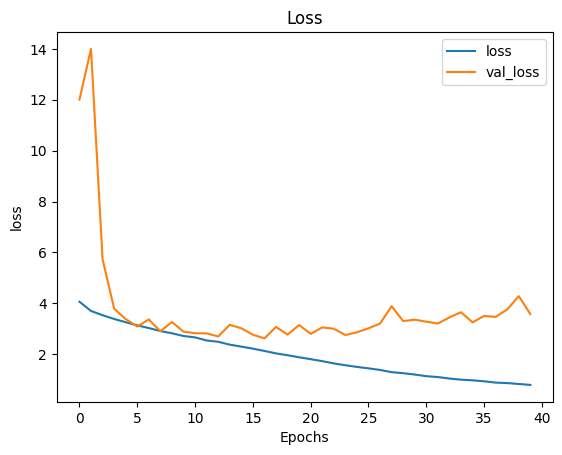

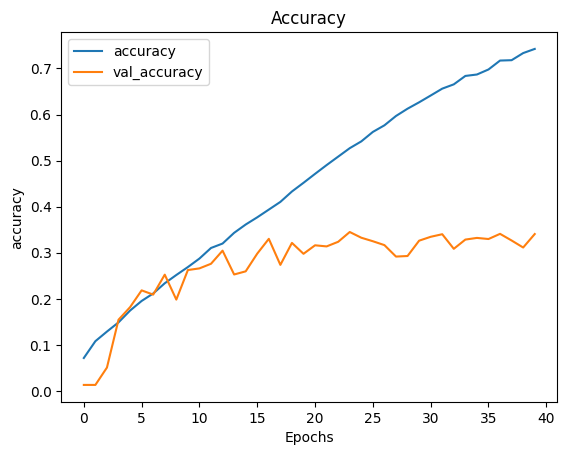

98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - Top2: 0.4652 - accuracy: 0.3335 - loss: 3.6304
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


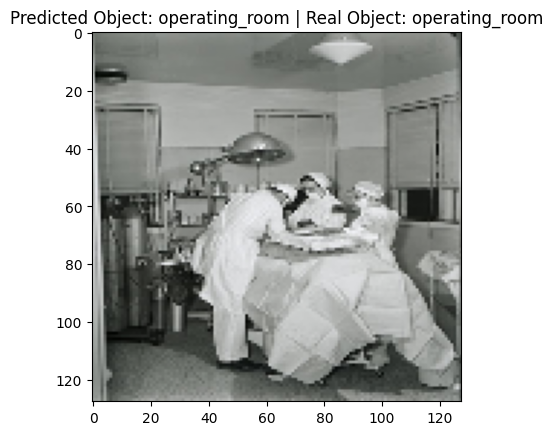

In [35]:
model_more_conv_filters = tf.keras.models.Sequential(
    [
        layers.Input(shape=(*size, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_test.shape[1], activation='softmax')
    ]
)

model_more_conv_filters.summary()
model_more_conv_filters.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
predict(model_more_conv_filters, 64, 40)

# New Baseline (More Conv2D, More Dropouts, Less MaxPooling (First few Conv2D))

In [34]:
model_new_baseline = tf.keras.models.Sequential(
    [
        layers.Input(shape=(*size, 3)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_test.shape[1], activation='softmax')
    ]
)

model_new_baseline.summary()
model_new_baseline.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 67)             │        17,21

 Total params: 855,235 (3.26 MB)

 Trainable params: 853,891 (3.26 MB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - Top2: 0.0760 - accuracy: 0.0412 - loss: 4.6349 - val_Top2: 0.0545 - val_accuracy: 0.0112 - val_loss: 8.6857
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - Top2: 0.1245 - accuracy: 0.0653 - loss: 3.9119 - val_Top2: 0.0818 - val_accuracy: 0.0445 - val_loss: 6.4279
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - Top2: 0.1469 - accuracy: 0.0792 - loss: 3.8064 - val_Top2: 0.0802 - val_accuracy: 0.0305 - val_loss: 5.0747
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - Top2: 0.1548 - accuracy: 0.0799 - loss: 3.7547 - val_Top2: 0.2096 - val_accuracy: 0.1086 - val_loss: 3.6432
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - Top2: 0.1783 - accuracy: 0.1011 - loss: 3.6856 - val_Top2: 0.2120 - val_accuracy: 0.1238 - val_loss: 3.5839
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - Top2: 0.1890 - accuracy: 0.1023 - loss: 3.6437 - val_Top2: 0.2313 - val_accuracy: 0.1331 - val_loss: 3.4583
Epoch 7/100
156/

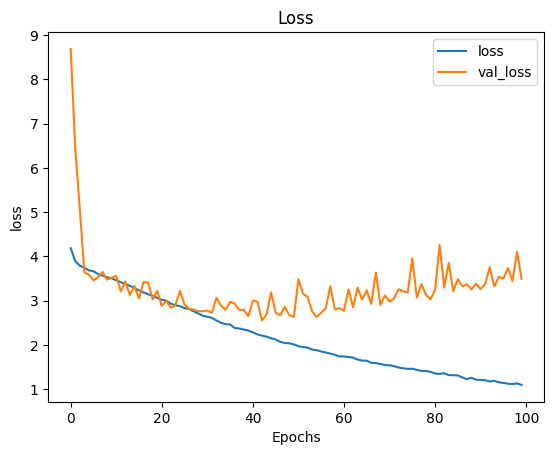

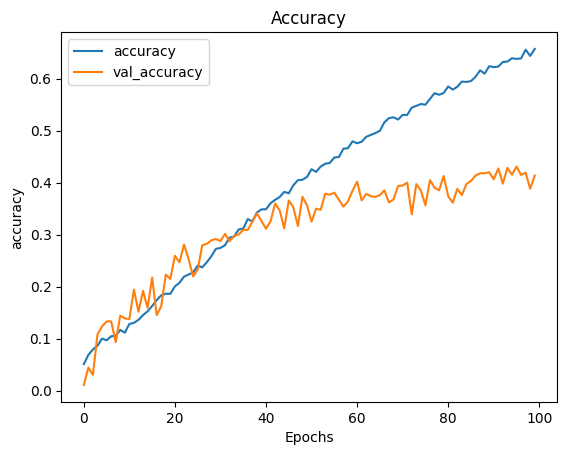

98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - Top2: 0.5376 - accuracy: 0.4127 - loss: 3.3560
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step


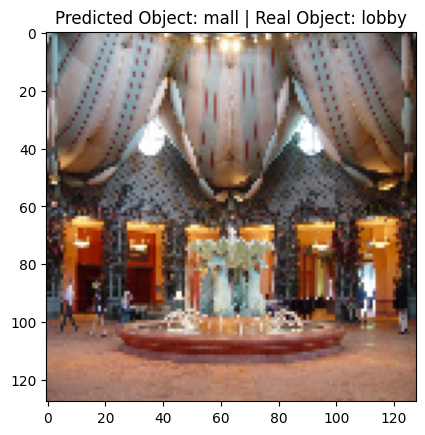

In [35]:
predict(model_new_baseline, 64, 100)

# More Conv2D

In [18]:
model_new_more_conv = tf.keras.models.Sequential(
    [
        layers.Input(shape=(*size, 3)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.MaxPooling2D(4, 4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_test.shape[1], activation='softmax')
    ]
)

model_new_more_conv.summary()
model_new_more_conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             

 Total params: 1,640,995 (6.26 MB)

 Trainable params: 1,638,691 (6.25 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - Top2: 0.0884 - accuracy: 0.0468 - loss: 4.6478 - val_Top2: 0.0914 - val_accuracy: 0.0501 - val_loss: 5.3382
Epoch 2/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - Top2: 0.1394 - accuracy: 0.0703 - loss: 3.9349 - val_Top2: 0.0990 - val_accuracy: 0.0557 - val_loss: 4.1981
Epoch 3/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step - Top2: 0.1516 - accuracy: 0.0888 - loss: 3.8209 - val_Top2: 0.1198 - val_accuracy: 0.0633 - val_loss: 3.9745
Epoch 4/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - Top2: 0.1767 - accuracy: 0.0945 - loss: 3.6921 - val_Top2: 0.2084 - val_accuracy: 0.1263 - val_loss: 3.6646
Epoch 5/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 465s 3s/step - Top2: 0.1776 - accuracy: 0.0935 - loss: 3.6659 - val_Top2: 0.1683 - val_accuracy: 0.0950 - val_loss: 4.0228
Epoch 6/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - Top2: 0.2002 - accuracy: 0.1102 - loss: 3.5537 - val_Top2: 0.2477 - val_accuracy: 0.1451 - val_loss: 3.5095
Epoch 7/70
156/156 ━━━

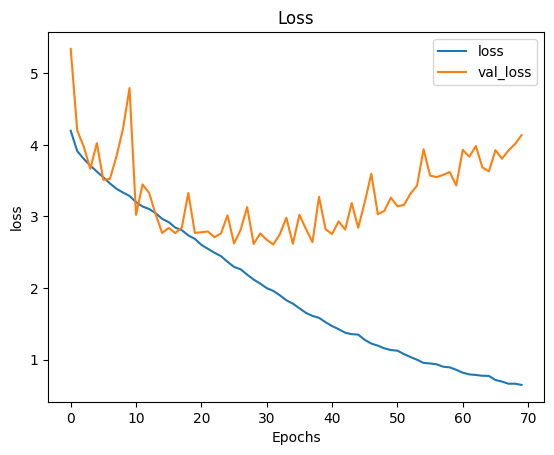

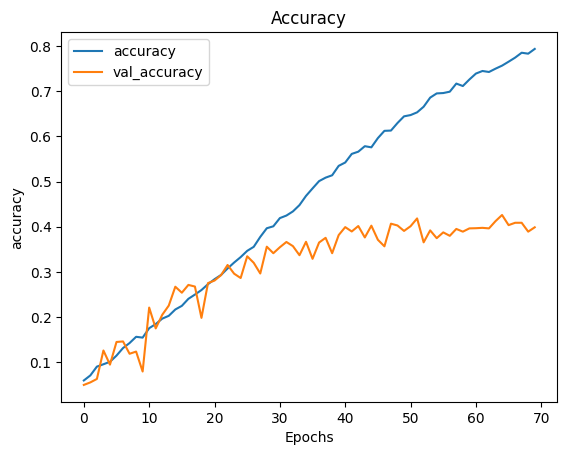

98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - Top2: 0.5166 - accuracy: 0.3950 - loss: 4.1938
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step


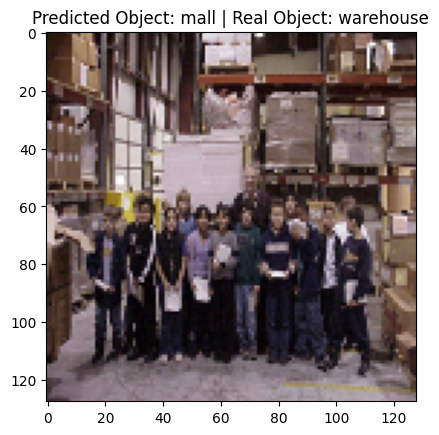

In [22]:
predict(model_new_more_conv, 64, 70)

# Less Conv2D, More filters

In [24]:
model_less_conv_more_filter = tf.keras.models.Sequential(
    [
        layers.Input(shape=(*size, 3)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),
        layers.Dropout(0.3),

        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_test.shape[1], activation='softmax')
    ]
)

model_less_conv_more_filter.summary()
model_less_conv_more_filter.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 67)             │        68,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649,347 (13.92 MB)

 Trainable params: 3,647,555 (13.91 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - Top2: 0.0968 - accuracy: 0.0572 - loss: 6.0047 - val_Top2: 0.0389 - val_accuracy: 0.0132 - val_loss: 17.1081
Epoch 2/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - Top2: 0.1681 - accuracy: 0.0922 - loss: 3.8029 - val_Top2: 0.0557 - val_accuracy: 0.0232 - val_loss: 17.4664
Epoch 3/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - Top2: 0.1874 - accuracy: 0.1097 - loss: 3.6171 - val_Top2: 0.0798 - val_accuracy: 0.0265 - val_loss: 10.4112
Epoch 4/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - Top2: 0.2275 - accuracy: 0.1279 - loss: 3.5129 - val_Top2: 0.1860 - val_accuracy: 0.1102 - val_loss: 3.9218
Epoch 5/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - Top2: 0.2342 - accuracy: 0.1342 - loss: 3.4250 - val_Top2: 0.2729 - val_accuracy: 0.1647 - val_loss: 3.4276
Epoch 6/70
156/156 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - Top2: 0.2595 - accuracy: 0.1530 - loss: 3.2998 - val_Top2: 0.1206 - val_accuracy: 0.0693 - val_loss: 5.5926
Epoch 7/70
156/156 

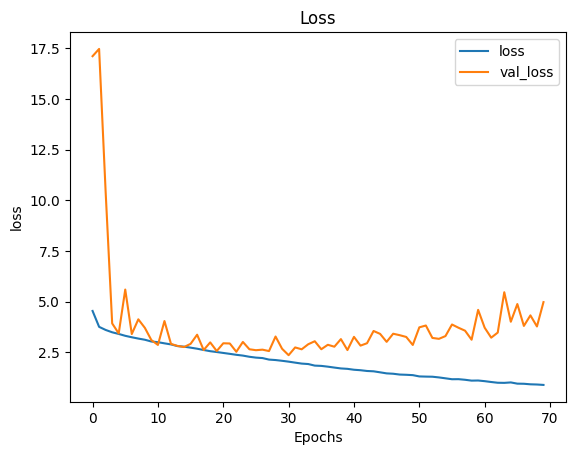

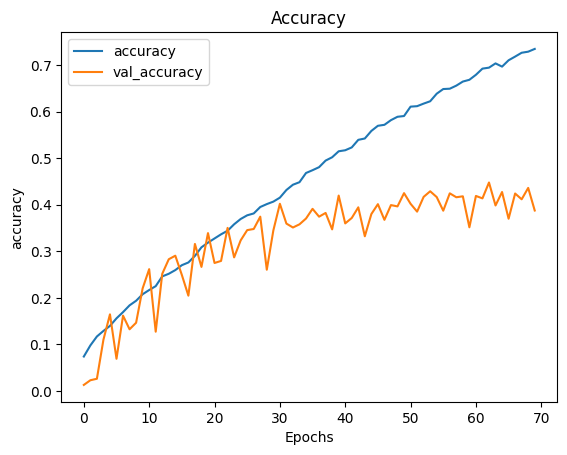

98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - Top2: 0.5087 - accuracy: 0.3835 - loss: 4.7555
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step


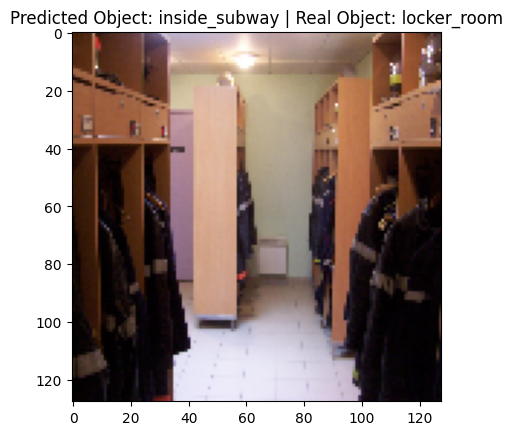

In [25]:
predict(model_less_conv_more_filter, 64, 70)